# Preliminaries

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np

import fbprophet
from fbprophet import Prophet

#Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-dark')

#DateTime
import datetime as dt

#Models
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor

#SKLearn
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler

#Time to run Program
import time 

# Configuration

In [ ]:
class config:
  TRAINING_FILE_PATH = "/content/drive/MyDrive/Data Science/IIT Kanpur Intern/Data/states.csv"
  END_DATE = '2021-04-30'
  TARGET = "y"

# Utils

In [ ]:
#Hackathon Metric
def predict(model, model_features):
  pred_train = model.predict(X_train[model_features])
  pred_val = model.predict(X_val[model_features])

  print(f"Train RMSE = {np.sqrt(mean_squared_error(y_train, pred_train))}")
  print(f"Test RMSE = {np.sqrt(mean_squared_error(y_val, pred_val))}")

def run_gradient_boosting(clf, fit_params, train, test, features):
  N_SPLITS = 5
  oofs = np.zeros(len(train))
  preds = np.zeros((len(test)))

  target = train[config.TARGET]

  folds = StratifiedKFold(n_splits = N_SPLITS)
  stratified_target = pd.qcut(train[config.TARGET], 10, labels = False, duplicates='drop')

  feature_importances = pd.DataFrame()

  for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, stratified_target)):
    print(f'\n------------- Fold {fold_ + 1} -------------')

    ### Training Set
    X_trn, y_trn = train[features].iloc[trn_idx], target.iloc[trn_idx]

    ### Validation Set
    X_val, y_val = train[features].iloc[val_idx], target.iloc[val_idx]

    ### Test Set
    X_test = test[features]

    scaler = StandardScaler()
    _ = scaler.fit(X_trn)

    X_trn = scaler.transform(X_trn)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)
    
    _ = clf.fit(X_trn, y_trn, eval_set = [(X_val, y_val)], **fit_params)

    fold_importance = pd.DataFrame({'fold': fold_ + 1, 'feature': features, 'importance': clf.feature_importances_})
    feature_importances = pd.concat([feature_importances, fold_importance], axis=0)

    ### Instead of directly predicting the classes we will obtain the probability of positive class.
    preds_val = clf.predict(X_val)
    preds_test = clf.predict(X_test)

    fold_score = metric(y_val, preds_val)
    print(f'\nRMSE score for validation set is {fold_score}')

    oofs[val_idx] = preds_val
    preds += preds_test / N_SPLITS


  oofs_score = metric(target, oofs)
  print(f'\n\nRMSE for oofs is {oofs_score}')

  feature_importances = feature_importances.reset_index(drop = True)
  fi = feature_importances.groupby('feature')['importance'].mean().sort_values(ascending = False)[:20][::-1]
  fi.plot(kind = 'barh', figsize=(12, 6))

  return oofs, preds, fi

def metric(y_true, y_pred):
  return np.sqrt(mean_squared_error(y_true, y_pred))

# Dataset

In [ ]:
df = pd.read_csv(config.TRAINING_FILE_PATH)
df.head()

,Date,State,Confirmed,Recovered,Deceased,Other,Tested
0,2020-01-30,Kerala,1,0,0,0,NaN
1,2020-01-30,India,1,0,0,0,NaN
2,2020-02-02,Kerala,2,0,0,0,NaN
3,2020-02-02,India,2,0,0,0,NaN
4,2020-02-03,Kerala,3,0,0,0,NaN


In [ ]:
# Lowercase column names
df.columns = [col.lower() for col in df.columns]

# Make `date` column in `datetime` format
df['date'] = pd.to_datetime(df['date'])
df['ds'] = df['date']

# Column for Active Cases
df['active'] = df.confirmed - (df.recovered + df.deceased)
# df['active'] = np.log1p(df['active'])

# Set target column as 'y'
df['y'] = df['active']


# Create dataset with total cases in India
df2 = df.loc[df.state == "India"]
# df2 = df2[["ds", "y"]]

In [ ]:
df2.head()

,ds,y
1,2020-01-30,1
3,2020-02-02,2
5,2020-02-03,3
7,2020-02-14,0
11,2020-03-02,2


# Model

In [ ]:
model_fb = Prophet(
            growth = 'linear', 
            seasonality_mode = 'multiplicative',  
            changepoint_prior_scale = 30,
            seasonality_prior_scale = 15,
        )

# Train

In [ ]:
def run():

    # Define Train Dataset
    X_train = df2[df2['ds'] <= config.END_DATE]

    # Load Model
    model = model_fb

    # Train the model
    print("\n---------- Model Training initiated. ----------\n")

    model.fit(X_train)

    print("\n---------- Model Training complete. ----------\n")

    return model

if __name__ == "__main__":
  model = run()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



---------- Model Training initiated. ----------


---------- Model Training complete. ----------



# Inference

In [ ]:
X_test = df2[df2['ds'] > config.END_DATE]

# Obtain Predictions
print("\n---------- Model is calculating predictions. ----------\n")

preds = model.predict(X_test)
print("\n---------- Model Predictions calculation complete. ----------\n")

# Evaluate Model
rmse = np.sqrt(mean_squared_error(X_test['y'], preds['yhat']))
print(f"RMSE Score: {rmse}")


---------- Model is calculating predictions. ----------


---------- Model Predictions calculation complete. ----------

RMSE Score: 149347.6357144611


In [ ]:
 df_test = df2

ds    datetime64[ns]
y              int64
dtype: object

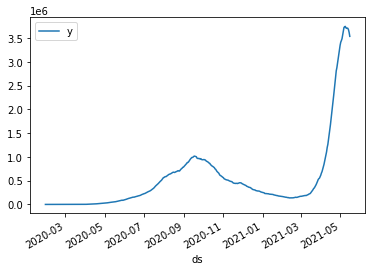

In [ ]:
df2.plot(x = 'ds')

# LightGBM

# Additional Data

In [ ]:
# case = pd.read_csv("/content/drive/MyDrive/Data Science/IIT Kanpur Intern/Data/case_time_series.csv")
vac = pd.read_csv("/content/drive/MyDrive/Data Science/IIT Kanpur Intern/Data/cowin_vaccine_data_statewise.csv")
rtpcr = pd.read_csv("/content/drive/MyDrive/Data Science/IIT Kanpur Intern/Data/icmr_rtpcr_tests_daily.csv")

In [ ]:
vac.head()

,Updated On,State,Total Individuals Vaccinated,Total Sessions Conducted,Total Sites,First Dose Administered,Second Dose Administered,Male(Individuals Vaccinated),Female(Individuals Vaccinated),Transgender(Individuals Vaccinated),Total Covaxin Administered,Total CoviShield Administered,AEFI,18-30 years (Age),30-45 years (Age),45-60 years (Age),60+ years (Age),Total Doses Administered
0,16/01/2021,India,48276.0,3455.0,2957.0,48276.0,0.0,23757.0,24517.0,2.0,579.0,47697.0,NaN,NaN,NaN,NaN,NaN,48276
1,17/01/2021,India,58604.0,8532.0,4954.0,58604.0,0.0,27348.0,31252.0,4.0,635.0,57969.0,NaN,NaN,NaN,NaN,NaN,58604
2,18/01/2021,India,99449.0,13611.0,6583.0,99449.0,0.0,41361.0,58083.0,5.0,1299.0,98150.0,NaN,NaN,NaN,NaN,NaN,99449
3,19/01/2021,India,195525.0,17855.0,7951.0,195525.0,0.0,81901.0,113613.0,11.0,3017.0,192508.0,NaN,NaN,NaN,NaN,NaN,195525
4,20/01/2021,India,251280.0,25472.0,10504.0,251280.0,0.0,98111.0,153145.0,24.0,3946.0,247334.0,NaN,NaN,NaN,NaN,NaN,251280


In [ ]:
vac = vac.loc[vac.State == "India"]
vac["ds"] = vac["Updated On"]

vac.drop(["Updated On", "State"], axis = 1, inplace = True)

vac["ds"] = pd.to_datetime(vac["ds"])

In [ ]:
main_df = pd.merge(df2, vac, how = 'outer', on = "ds")

In [ ]:
rtpcr = rtpcr.loc[rtpcr["State"] == "Total"]

In [ ]:
rtpcr.head()

,State,01/06/2020,02/06/2020,03/06/2020,04/06/2020,05/06/2020,06/06/2020,07/06/2020,08/06/2020,09/06/2020,10/06/2020,11/06/2020,12/06/2020,13/06/2020,14/06/2020,15/06/2020,16/06/2020,17/06/2020,18/06/2020,19/06/2020,20/06/2020,21/06/2020,22/06/2020,23/06/2020,24/06/2020,25/06/2020,26/06/2020,27/06/2020,28/06/2020,29/06/2020,30/06/2020,01/07/2020,02/07/2020,03/07/2020,04/07/2020,05/07/2020,06/07/2020,07/07/2020,08/07/2020,09/07/2020,...,01/03/2021,02/03/2021,03/03/2021,04/03/2021,05/03/2021,06/03/2021,07/03/2021,08/03/2021,09/03/2021,10/03/2021,11/03/2021,12/03/2021,13/03/2021,14/03/2021,15/03/2021,16/03/2021,17/03/2021,18/03/2021,19/03/2021,20/03/2021,21/03/2021,22/03/2021,23/03/2021,24/03/2021,25/03/2021,26/03/2021,27/03/2021,28/03/2021,29/03/2021,30/03/2021,31/03/2021,01/04/2021,02/04/2021,03/04/2021,04/04/2021,05/04/2021,06/04/2021,07/04/2021,08/04/2021,09/04/2021
37,Total,1624406,1714050,1798389,1882908,1969109,2057689,2115594,2214138,2309618,2408456,2510125,2615142,2718053,2785066,2911503,3040228,3173113,3302547,3440718,3578104,3655298,3808749,3956040,4106453,4252541,4405716,4559014,4649251,4817593,4989004,5154925,5332085,5515466,5701788,5804302,6014391,6220654,6426362,6640772,...,100350789,100756816,101162374,101561754,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,116068403,116824133,116824133,117547722,0.0,0.0


In [ ]:
col = rtpcr.columns
col = col[1:]
col

Index(['01/06/2020', '02/06/2020', '03/06/2020', '04/06/2020', '05/06/2020',
       '06/06/2020', '07/06/2020', '08/06/2020', '09/06/2020', '10/06/2020',
       ...
       '31/03/2021', '01/04/2021', '02/04/2021', '03/04/2021', '04/04/2021',
       '05/04/2021', '06/04/2021', '07/04/2021', '08/04/2021', '09/04/2021'],
      dtype='object', length=313)

In [ ]:
rtpcr_df = pd.DataFrame()
rtpcr_df["ds"] = col

In [ ]:
rtpcr_df.head()

,ds
0,01/06/2020
1,02/06/2020
2,03/06/2020
3,04/06/2020
4,05/06/2020


In [ ]:
rtpcr.reset_index(inplace = True)

In [ ]:
rtpcr.head()

,index,37
0,State,Total
1,01/06/2020,1624406
2,02/06/2020,1714050
3,03/06/2020,1798389
4,04/06/2020,1882908


In [ ]:
col2 = rtpcr[37]

In [ ]:
col2 = col2[1:]

In [ ]:
col2

2        1714050
3        1798389
4        1882908
5        1969109
6        2057689
         ...    
309    116824133
310    116824133
311    117547722
312            0
313            0
Name: 37, Length: 312, dtype: object

In [ ]:
rtpcr_df["rtpcr"] = col2

In [ ]:
rtpcr_df = rtpcr_df.shift(-1)

In [ ]:
rtpcr_df

,ds,rtpcr
0,02/06/2020,1624406
1,03/06/2020,1714050
2,04/06/2020,1798389
3,05/06/2020,1882908
4,06/06/2020,1969109
...,...,...
308,06/04/2021,116824133
309,07/04/2021,116824133
310,08/04/2021,117547722
311,09/04/2021,0


In [ ]:
rtpcr_df["ds"] = pd.to_datetime(rtpcr_df["ds"])

In [ ]:
main_df = pd.merge(main_df, rtpcr_df, how = "outer", on = "ds")
main_df.drop(["date"], axis = 1, inplace = True)
main_df = main_df[:-1]
main_df.fillna(0, inplace = True)

In [ ]:
main_df['year'] = main_df['ds'].dt.year
main_df['month'] = main_df['ds'].dt.month
main_df['week'] = main_df['ds'].dt.isocalendar().week  

In [ ]:
train = main_df[main_df['ds'] <= config.END_DATE]
test = main_df[main_df['ds'] > config.END_DATE]

In [ ]:
features = ['confirmed', 'recovered', 'deceased', 'other', 'tested','y', 'Total Individuals Vaccinated',
       'Total Sessions Conducted', 'Total Sites ', 'First Dose Administered',
       'Second Dose Administered', 'Male(Individuals Vaccinated)',
       'Female(Individuals Vaccinated)', 'Transgender(Individuals Vaccinated)',
       'Total Covaxin Administered', 'Total CoviShield Administered', 'AEFI',
       '18-30 years (Age)', '30-45 years (Age)', '45-60 years (Age)',
       '60+ years (Age)', 'Total Doses Administered', 'rtpcr', 'year', 'month']

In [ ]:
%%time
model = LGBMRegressor(n_estimators = 5000,
                        learning_rate = 0.01,
                        colsample_bytree = 0.76,
                        metric = 'None',
                        )
fit_params = {'verbose': 300, 'early_stopping_rounds': 200, 'eval_metric': 'rmse'}

lgb_oofs, lgb_preds, fi = run_gradient_boosting(clf = model, fit_params = fit_params, train = train, test = test, features = features)

In [ ]:
main_df.tail(50)

,state,confirmed,recovered,deceased,other,tested,ds,active,y,Total Individuals Vaccinated,Total Sessions Conducted,Total Sites,First Dose Administered,Second Dose Administered,Male(Individuals Vaccinated),Female(Individuals Vaccinated),Transgender(Individuals Vaccinated),Total Covaxin Administered,Total CoviShield Administered,AEFI,18-30 years (Age),30-45 years (Age),45-60 years (Age),60+ years (Age),Total Doses Administered,rtpcr,year,month,week
446,0,0.0,0.0,0.0,0.0,0.0,2021-07-02,0.0,0.0,5168099.0,153231.0,35778.0,5168099.0,0.0,1928947.0,3238273.0,879.0,206130.0,4961969.0,0.0,0.0,0.0,0.0,0.0,5168099.0,92355380.0,2021,7,26
447,0,0.0,0.0,0.0,0.0,0.0,2021-08-02,0.0,0.0,5615499.0,164116.0,36740.0,5615499.0,0.0,2211020.0,3403576.0,903.0,290785.0,5324714.0,0.0,0.0,0.0,0.0,0.0,5615499.0,92533662.0,2021,8,31
448,0,0.0,0.0,0.0,0.0,0.0,2021-09-02,0.0,0.0,6002474.0,175556.0,38131.0,6002474.0,0.0,2458329.0,3543208.0,937.0,363692.0,5638782.0,0.0,0.0,0.0,0.0,0.0,6002474.0,92922448.0,2021,9,35
449,0,0.0,0.0,0.0,0.0,0.0,2021-10-02,0.0,0.0,6462270.0,187224.0,39339.0,6462270.0,0.0,2785194.0,3676114.0,962.0,480760.0,5981510.0,0.0,0.0,0.0,0.0,0.0,6462270.0,93290409.0,2021,10,39
450,0,0.0,0.0,0.0,0.0,0.0,2021-11-02,0.0,0.0,6958553.0,197650.0,40332.0,6958553.0,0.0,3153649.0,3803908.0,996.0,609108.0,6349445.0,0.0,0.0,0.0,0.0,0.0,6958553.0,93650040.0,2021,11,44
451,0,0.0,0.0,0.0,0.0,0.0,2021-12-02,0.0,0.0,7423817.0,207633.0,40799.0,7423817.0,0.0,3504429.0,3918381.0,1007.0,740517.0,6683300.0,0.0,0.0,0.0,0.0,0.0,7423817.0,94009093.0,2021,12,48
452,0,0.0,0.0,0.0,0.0,0.0,2021-06-03,0.0,0.0,15438495.0,802800.0,60930.0,15438495.0,3732333.0,8488627.0,6948195.0,1673.0,1434272.0,14004223.0,0.0,0.0,0.0,0.0,0.0,19170828.0,0.0,2021,6,22
453,0,0.0,0.0,0.0,0.0,0.0,2021-07-03,0.0,0.0,15541529.0,862720.0,63187.0,15541529.0,3747137.0,8545982.0,6993867.0,1680.0,1440857.0,14100672.0,0.0,0.0,0.0,0.0,0.0,19288666.0,0.0,2021,7,26
454,0,0.0,0.0,0.0,0.0,0.0,2021-08-03,0.0,0.0,16976138.0,923939.0,64854.0,16976138.0,4062362.0,9298005.0,7676312.0,1821.0,1495593.0,15480545.0,0.0,0.0,0.0,0.0,0.0,21038500.0,0.0,2021,8,31
455,0,0.0,0.0,0.0,0.0,0.0,2021-09-03,0.0,0.0,18360243.0,3632230.0,22562.0,14003206.0,4357037.0,10044921.0,8313353.0,1967.0,1619279.0,16739804.0,0.0,0.0,0.0,0.0,0.0,18360243.0,0.0,2021,9,35


In [ ]:
pred_temp = main_df.tail(1)
pred_temp = pred_temp[features]
model.predict(pred_temp)

array([459019.63647994])

In [ ]:
main_df = main_df.loc[main_df["y"] == 0]